In [1]:
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
# suppress rdkit warning
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [2]:
def group_f1_b(df): 
    label = np.array(df.Class_b.tolist(), dtype=int)
    pred = np.array(df.Pred_b.tolist(), dtype=float)
    pred = np.where(pred > 0.5, 1, 0)
    score = metrics.f1_score(label, pred, average='micro')
    return score

def group_kappa_b(df): 
    label = np.array(df.Class_b.tolist(), dtype=int)
    pred = np.array(df.Pred_b.tolist(), dtype=float)
    pred = np.where(pred > 0.5, 1, 0)
    score = metrics.cohen_kappa_score(label, pred)
    return score

def group_acc_b(df): 
    label = np.array(df.Class_b.tolist(), dtype=int)
    pred = np.array(df.Pred_b.tolist(), dtype=float)
    pred = np.where(pred > 0.5, 1, 0)
    score = metrics.accuracy_score(label, pred)
    return score

def group_auc_b(df): 
    label = np.array(df.Class_b.tolist(), dtype=int)
    pred = np.array(df.Pred_b.tolist(), dtype=float)
    score = metrics.roc_auc_score(label, pred)
    return score

In [3]:
from scipy.special import softmax

def binary_cls(cls):
    if cls == 0 or cls == 1:
        return 0
    elif cls == 2 or cls == 3:
        return 1
    else:
        return None
    
def binary_pred(pred):
    pred = np.array(pred.split(','), dtype=float)
    pred_b = np.array([pred[0]+pred[1], pred[2]+pred[3]])
    pred_b = softmax(pred_b)
    return pred_b[1] # the probability to greater label

## 1. Load the dataset

In [4]:
suppl = Chem.SDMolSupplier("../data/ChirBase/chirbase_clean.sdf")
mols = [x for x in suppl if x is not None]

In [5]:
def convert2cls(chir, csp_category): 
    if csp_category == '1': 
        # For polysaccharide CSPs:
        if chir < 1.15:
            y = 0
        elif chir < 1.2:
            y = 1
        elif chir < 2.1:
            y = 2
        else:
            y = 3
    elif csp_category == '2': 
        # For Pirkle CSPs:
        if chir < 1.05: 
            y = 0
        elif chir < 1.15:
            y = 1
        elif chir < 2: 
            y = 2
        else:
            y = 3
    else:
        raise Exception("The category for CSP should be 1 or 2, rather than {}.".format(csp_category))
    return y

In [6]:
df_dict = {'SMILES': [], 'MB': [], 'K2/K1': [], 'Y': []}

for mol in mols: 
    if mol.HasProp('encode_mobile_phase'):
        mb = mol.GetProp('encode_mobile_phase')
    else:
        mb = 'unknown'
    smiles = Chem.MolToSmiles(mol)
    chir = round(float(mol.GetProp('k2/k1')), 4)
    y = convert2cls(chir, mol.GetProp('mobile_phase_category'))
    
    df_dict['SMILES'].append(smiles)
    df_dict['K2/K1'].append(chir)
    df_dict['MB'].append(mb)
    df_dict['Y'].append(y)

df_label = pd.DataFrame.from_dict(df_dict)

In [7]:
df_label

,SMILES,MB,K2/K1,Y
0,CCC(=O)O[C@@H](C)c1ccccc1,15,1.0100,0
1,CC(=O)O[C@@H](C)c1ccccc1,15,1.0300,0
2,O=C(O)[C@@H](Cl)c1ccccc1,15,1.0300,0
3,CCC[C@@H](C(N)=O)c1ccc(O)c(O)c1,15,1.3100,2
4,COc1ccccc1[C@H](C)O,15,1.0400,0
...,...,...,...,...
43962,O=C(c1ccccc1)c1ccc2n1CC[C@H]2C(=O)O,13,2.0000,3
43963,CCOc1ccccc1OCCN[C@@H](C)Cc1ccc(OC)c(S(N)(=O)=O)c1,11,1.8069,2
43964,CCC[S@@](=O)c1ccc2[nH]c(NC(=O)OC)nc2c1,16,2.1600,3
43965,NC(=S)N1N=C(c2ccc(-c3ccccc3)cc2)C[C@@H]1c1ccccc1,6,5.0000,3


Keep the compounds have more than one CSP labeled

In [8]:
df_label = df_label.sort_values(['SMILES', 'MB', 'K2/K1'], ascending=False).drop_duplicates(['SMILES', 'MB']).sort_index()
df_label = df_label.groupby(['SMILES']).filter(lambda x: len(x) > 1) # labeled more than 1 CSP

In [9]:
df_label_all = df_label.copy()

Keep the largest K2/K1 of each compound as the best separatable mobile phase

In [10]:
df_label = df_label.sort_values(['SMILES', 'K2/K1'], ascending=False).drop_duplicates(['SMILES']).sort_index()

In [11]:
df_label

,SMILES,MB,K2/K1,Y
3,CCC[C@@H](C(N)=O)c1ccc(O)c(O)c1,15,1.3100,2
22,c1ccc(CN2CCC[C@H]2c2cccnc2)cc1,15,1.1800,1
44,CN1C2CCC1CC(OC(=O)[C@H](O)c1ccccc1)C2,8,3.1300,3
46,CC(C)NC[C@H](O)c1ccc(O)c(O)c1,8,1.2800,2
48,CN[C@H](C)Cc1ccccc1OC,8,1.4100,2
...,...,...,...,...
43958,COc1ccc2c(=O)c3cc(C(=O)N[C@@H](CO)C(C)C)ccc3oc2c1,11,10.5000,3
43959,COc1ccc2c(=O)c3cc(C(=O)N[C@H](C)CO)ccc3oc2c1,11,6.9400,3
43960,COc1ccc2c(=O)c3cc(C(=O)NC[C@@H](C)O)ccc3oc2c1,11,1.5100,2
43962,O=C(c1ccccc1)c1ccc2n1CC[C@H]2C(=O)O,13,2.0000,3


## 2. Load the prediction results

In [12]:
dfs = []
for mb in range(18): 
    for i in range(5):
        dfs.append(pd.read_csv('../results1203/molnet_chirality_cls_etkdg_csp{}-5fold_tl_{}.csv'.format(str(mb), str(i)), 
                               sep='\t', index_col=0))
        
df_pred = pd.concat(dfs, ignore_index=True)

In [13]:
df_pred['Class_b'] = df_pred['Class'].apply(binary_cls)
df_pred['Pred_b'] = df_pred['Pred'].apply(binary_pred)

Duplecated the SMILES and MB (keep largest probability)

In [14]:
df_pred = df_pred.sort_values(['SMILES', 'MB', 'Pred_b'], ascending=False).drop_duplicates(['SMILES', 'MB']).sort_index()

In [15]:
df_pred

,index,ID,SMILES,MB,Pred_avg,Class,Pred,Class_b,Pred_b
0,0,chira_016001,CN1[C@H]2CC[C@@H]1C[C@H](OC(=O)[C@@H](CO)c1ccc...,0,"3.1648135e-05,3.0319711e-09,0.99995697,1.14989...",2,"3.1648134608985856e-05,3.0319711186166387e-09,...",1,0.731046
2,2,chira_016042,O=C1Nc2ccc(Cl)cc2C(c2ccccc2)=N[C@@H]1O,0,"4.368581e-06,2.0285856e-06,0.9999292,6.440911e-05",2,"4.368580903246766e-06,2.028585640800884e-06,0....",1,0.731056
4,4,chira_016052,CC(C)NC[C@H](O)COc1cccc2ccccc12,0,"7.1867266e-06,3.4107547e-06,0.99972755,0.00026...",2,"7.186726634245133e-06,3.4107547435269225e-06,0...",1,0.731054
6,6,chira_019398,COc1ccc2c3c1Oc1ccccc1C[C@@H]3N(C)C2=O,0,"7.628741e-07,0.9999993,8.55087e-16,1.9879467e-08",1,"7.628740945619938e-07,0.9999992847442627,8.550...",0,0.268941
8,8,chira_019468,CCOC(=O)C1=C(C)NC(=S)N[C@@H]1c1cccc(O)c1,0,"1.2800469e-08,1.9123194e-09,0.99999833,1.72244...",2,"1.280046912910393e-08,1.9123194139325506e-09,0...",1,0.731059
...,...,...,...,...,...,...,...,...,...
87860,64,chira_024844,COC(=O)[C@H](COCc1ccccc1)NC(=O)C(C)(C)NC(=O)OC...,17,"0.019429388,8.807415e-05,0.979649,0.0008335525",0,"0.019429387524724007,8.80741499713622e-05,0.97...",0,0.723315
87862,66,chira_024850,C[C@@H](N)c1ccccc1,17,"0.005164127,0.00019982194,0.9922867,0.0023493809",0,"0.005164126865565777,0.00019982193771284074,0....",0,0.728944
87864,68,chira_024852,NC(=O)[C@@H]1CNCCN1,17,"0.00011608948,0.006094769,0.9936907,9.840292e-05",0,"0.00011608948261709884,0.006094769109040499,0....",0,0.728609
87866,70,chira_024854,C[C@H](O)c1ccc(Br)cc1F,17,"0.0014532706,3.1523525e-06,0.99844736,9.627675...",2,"0.001453270553611219,3.15235251946433e-06,0.99...",1,0.730486


## 3. Top-K 

In [16]:
def top_k(df):
    hitten_df = df.sort_values('Pred_b', ascending=False).reset_index(drop=True)
    data = {'SMILES': [hitten_df.loc[0, 'SMILES']], 
            'hitten_MB': [','.join(hitten_df['MB'].astype(str).tolist())], 
            'hitten_Prob': [','.join(hitten_df['Pred_b'].astype(str).tolist())]}
    return pd.DataFrame.from_dict(data)

def top_k_acc(hitten_mb, mb, k):
    if pd.isnull(hitten_mb): 
        return 0
    hitten_mb = hitten_mb.split(',')
    if mb in hitten_mb[:k]:
        return 1
    else:
        return 0

In [17]:
df_label1 = df_label[(df_label['Y'] == 2) | (df_label['Y'] == 3)]

df_pred1 = df_pred[df_pred['Class_b'] == 1]

df_topk = df_pred1.groupby('SMILES').apply(top_k).reset_index(drop=True)
df_topk = df_topk.merge(df_label1, how='right', on='SMILES')

In [18]:
df_topk

,SMILES,hitten_MB,hitten_Prob,MB,K2/K1,Y
0,CCC[C@@H](C(N)=O)c1ccc(O)c(O)c1,15,0.7310573416361467,15,1.3100,2
1,CN1C2CCC1CC(OC(=O)[C@H](O)c1ccccc1)C2,NaN,NaN,8,3.1300,3
2,CC(C)NC[C@H](O)c1ccc(O)c(O)c1,8,0.7310518968895305,8,1.2800,2
3,CN[C@H](C)Cc1ccccc1OC,"8,2","0.730983370254686,0.6663349444132846",8,1.4100,2
4,CCC[C@@H](C)NC(=O)c1ccccc1,10,0.7310562450861489,10,1.5300,2
...,...,...,...,...,...,...
3916,COc1ccc2c(=O)c3cc(C(=O)N[C@@H](CO)C(C)C)ccc3oc2c1,"11,12,2,3","0.7309708474381238,0.4392098856303303,0.268979...",11,10.5000,3
3917,COc1ccc2c(=O)c3cc(C(=O)N[C@H](C)CO)ccc3oc2c1,"11,12,2,3","0.7308951452562324,0.48915970741565334,0.36265...",11,6.9400,3
3918,COc1ccc2c(=O)c3cc(C(=O)NC[C@@H](C)O)ccc3oc2c1,11,0.730746920056139,11,1.5100,2
3919,O=C(c1ccccc1)c1ccc2n1CC[C@H]2C(=O)O,"11,12,13,6","0.7310437604568062,0.7310180095940081,0.706704...",13,2.0000,3


In [19]:
df_topk['top1_right'] = df_topk.apply(lambda x: top_k_acc(x['hitten_MB'], x['MB'], k=1), axis=1)
df_topk['top2_right'] = df_topk.apply(lambda x: top_k_acc(x['hitten_MB'], x['MB'], k=2), axis=1)
df_topk['top3_right'] = df_topk.apply(lambda x: top_k_acc(x['hitten_MB'], x['MB'], k=3), axis=1)

In [20]:
df_topk

,SMILES,hitten_MB,hitten_Prob,MB,K2/K1,Y,top1_right,top2_right,top3_right
0,CCC[C@@H](C(N)=O)c1ccc(O)c(O)c1,15,0.7310573416361467,15,1.3100,2,1,1,1
1,CN1C2CCC1CC(OC(=O)[C@H](O)c1ccccc1)C2,NaN,NaN,8,3.1300,3,0,0,0
2,CC(C)NC[C@H](O)c1ccc(O)c(O)c1,8,0.7310518968895305,8,1.2800,2,1,1,1
3,CN[C@H](C)Cc1ccccc1OC,"8,2","0.730983370254686,0.6663349444132846",8,1.4100,2,1,1,1
4,CCC[C@@H](C)NC(=O)c1ccccc1,10,0.7310562450861489,10,1.5300,2,1,1,1
...,...,...,...,...,...,...,...,...,...
3916,COc1ccc2c(=O)c3cc(C(=O)N[C@@H](CO)C(C)C)ccc3oc2c1,"11,12,2,3","0.7309708474381238,0.4392098856303303,0.268979...",11,10.5000,3,1,1,1
3917,COc1ccc2c(=O)c3cc(C(=O)N[C@H](C)CO)ccc3oc2c1,"11,12,2,3","0.7308951452562324,0.48915970741565334,0.36265...",11,6.9400,3,1,1,1
3918,COc1ccc2c(=O)c3cc(C(=O)NC[C@@H](C)O)ccc3oc2c1,11,0.730746920056139,11,1.5100,2,1,1,1
3919,O=C(c1ccccc1)c1ccc2n1CC[C@H]2C(=O)O,"11,12,13,6","0.7310437604568062,0.7310180095940081,0.706704...",13,2.0000,3,0,0,1


Random guess accuracy: 

In [21]:
df_label_all_csp_num = df_label_all.groupby(['SMILES']).size()

top_1_guess = np.mean([1/i for i in df_label_all_csp_num.tolist()])
top_2_guess = np.mean([2/i for i in df_label_all_csp_num.tolist()])
top_3_guess = np.mean([3/i if 3/i < 1. else 1. for i in df_label_all_csp_num.tolist()])

top_k_guess_plot = {'MB': ['Random Guess']*3, 'Acc': [top_1_guess, top_2_guess, top_3_guess], 'K': [0, 1, 2]}
top_k_guess_plot = pd.DataFrame.from_dict(top_k_guess_plot)

In [22]:
top_k_guess_plot

,MB,Acc,K
0,Random Guess,0.409924,0
1,Random Guess,0.819848,1
2,Random Guess,0.921984,2


Plot!

In [23]:
top_k_avg_acc = [df_topk['top1_right'].sum()/len(df_topk), 
                 df_topk['top2_right'].sum()/len(df_topk), 
                 df_topk['top3_right'].sum()/len(df_topk)]
top_k_avg_plot = {'MB': ['Average']*3, 'Acc': top_k_avg_acc, 'K': [0, 1, 2]}
top_k_avg_plot = pd.DataFrame.from_dict(top_k_avg_plot)

In [24]:
top_k_avg_plot

,MB,Acc,K
0,Average,0.610814,0
1,Average,0.899260,1
2,Average,0.956644,2


In [25]:
dfs = []
for i in range(1, 4): 
    key = 'top{}_right'.format(str(i))
    df_tmp = df_topk.groupby('MB').apply(lambda df: df[key].sum()/len(df)).to_frame(name='Acc').reset_index()
    df_tmp['K'] = str(i)
    dfs.append(df_tmp)
    
df_topk_plot = pd.concat(dfs, ignore_index=True)

In [26]:
df_topk_plot[df_topk_plot['Acc']<0.8]

,MB,Acc,K
0,0,0.689655,1
1,1,0.441176,1
2,10,0.769231,1
3,11,0.601333,1
4,12,0.425926,1
5,13,0.568966,1
6,14,0.660377,1
7,15,0.571429,1
8,16,0.663043,1
9,17,0.530612,1


In [27]:
df_topk_plot['MB'] = df_topk_plot['MB'].astype(int)
MB_dict = {0: 'Chiralpak IB', 1: 'Chirobiotic TAG', 2: 'Chirobiotic T', 3: 'Chirobiotic V', 4: 'Whelk-O', 
           5: 'Cyclobond I RN', 6: 'Chiralcel OJ (Lux Cellulose-3)', 7: 'Pirkle (R or S)-DNBPG', 
           8: 'Chiralcel OD (Lux Cellulose-1)', 9: 'Chiralpak AS', 10: 'Chiralcel OB',
           11: 'Chiralpak AD', 12: 'Chirobiotic R', 13: 'Chiral-AGP', 14: 'Chiralpak IC (Sepapak 5)', 
           15: 'Cyclobond I', 16: 'Chiralpak IA', 17: 'Ultron-ES-OVM',}
df_topk_plot = df_topk_plot.sort_values(['K', 'Acc'], ascending=True)
df_topk_plot['CSP_Names'] = df_topk_plot['MB'].apply(lambda x: MB_dict[x])

In [28]:
order = []
order_re = []

tmp = df_topk_plot['CSP_Names'].tolist()
tmp.reverse()

for csp_name1, csp_name2 in zip(df_topk_plot['CSP_Names'].tolist(), tmp):
    if csp_name1 not in order:
        order.append(csp_name1)
    if csp_name2 not in order_re:
        order_re.append(csp_name2)

In [29]:
order

['Chirobiotic R',
 'Chirobiotic TAG',
 'Ultron-ES-OVM',
 'Chiralpak AS',
 'Chiral-AGP',
 'Chiralcel OD (Lux Cellulose-1)',
 'Cyclobond I',
 'Chiralpak AD',
 'Chirobiotic V',
 'Chiralcel OJ (Lux Cellulose-3)',
 'Chirobiotic T',
 'Whelk-O',
 'Chiralpak IC (Sepapak 5)',
 'Chiralpak IA',
 'Chiralpak IB',
 'Chiralcel OB',
 'Cyclobond I RN',
 'Pirkle (R or S)-DNBPG']

In [30]:
df_topk_plot

,MB,Acc,K,CSP_Names
4,12,0.425926,1,Chirobiotic R
1,1,0.441176,1,Chirobiotic TAG
9,17,0.530612,1,Ultron-ES-OVM
17,9,0.561798,1,Chiralpak AS
5,13,0.568966,1,Chiral-AGP
16,8,0.569378,1,Chiralcel OD (Lux Cellulose-1)
7,15,0.571429,1,Cyclobond I
3,11,0.601333,1,Chiralpak AD
11,3,0.619048,1,Chirobiotic V
14,6,0.624697,1,Chiralcel OJ (Lux Cellulose-3)


Top-1 accuracy < 0.5: 

In [31]:
', '.join(df_topk_plot[(df_topk_plot['K'] == '1') & (df_topk_plot['Acc'] < 0.5)]['CSP_Names'].tolist())

'Chirobiotic R, Chirobiotic TAG'

In [32]:
# large_csp = ['Chiralpak IC (Sepapak 5)', 'Chirobiotic T', 'Chiralcel OB', 'Chiralpak IA', 'Ultron-ES-OVMa', 
#              'Whelk-O', 'Chiralpak AS', 'Chiralcel OJ (Lux Cellulose-3)', 'Chiralpak AD', 'Chiralcel OD (Lux Cellulose-1)']
large_csp = ['Chiralpak AS', 'Chiralcel OJ (Lux Cellulose-3)', 'Chiralpak AD', 'Chiralcel OD (Lux Cellulose-1)']

df_topk_plot[(df_topk_plot['K'] == '1') & df_topk_plot['CSP_Names'].isin(large_csp)]

,MB,Acc,K,CSP_Names
17,9,0.561798,1,Chiralpak AS
16,8,0.569378,1,Chiralcel OD (Lux Cellulose-1)
3,11,0.601333,1,Chiralpak AD
14,6,0.624697,1,Chiralcel OJ (Lux Cellulose-3)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


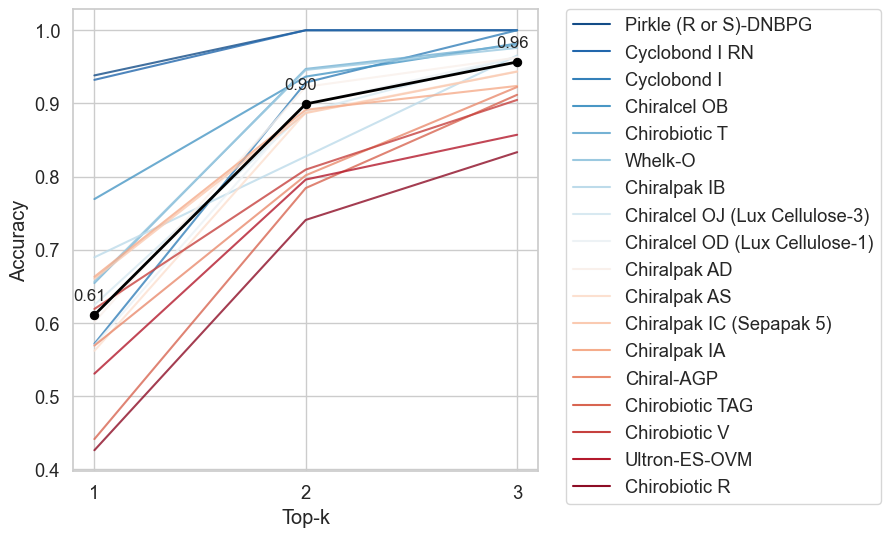

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.2)
sns.set_style("whitegrid")



fig, ax = plt.subplots(figsize=(6, 6))

sns.lineplot(data=df_topk_plot, x="K", y="Acc", hue="CSP_Names", hue_order=order_re, 
             ax=ax, 
             # legend=False, 
             # palette=['lightgray']*18,
             palette="RdBu_r", alpha=0.8, 
            )

sns.lineplot(data=top_k_avg_plot, x="K", y="Acc", hue="MB", 
             ax=ax, 
             legend=False, 
             style='MB', markers='o', markersize=6, markeredgecolor='black', 
             linewidth=2, 
             palette=['black'], alpha=1)
for idx, row in top_k_avg_plot.iterrows(): 
    x = row['K']
    y = row['Acc']
    ax.text(x-0.1, y+0.02, f'{y:.2f}', fontsize=12)
    
# sns.lineplot(data=top_k_guess_plot, x="K", y="Acc", hue="MB", 
#              ax=ax, 
#              legend=False, 
#              style='MB', markers='o', markersize=6, markeredgecolor='black', 
#              linewidth=2, dashes=[(4, 2)], 
#              palette=['black'], alpha=1)
# for idx, row in top_k_guess_plot.iterrows(): 
#     x = row['K']
#     y = row['Acc']
#     ax.text(x-0.1, y-0.05, f'{y:.2f}', fontsize=12)

plt.legend(bbox_to_anchor=(1.06, 1), ncol=1, loc='upper left', borderaxespad=0)
ax.set(xlabel='Top-k', ylabel='Accuracy')

plt.savefig('./best_csp_topk_acc1203.eps', dpi=600, bbox_inches='tight', format='eps')
plt.savefig('./best_csp_topk_acc1203.png', dpi=600, bbox_inches='tight')
plt.show()

In [34]:
df_cnt = df_label_all.groupby('MB').size().to_frame(name='Compound_Number')
df_cnt.reset_index(inplace=True)
df_cnt = df_cnt.rename(columns = {'index': 'MB'})

df_cnt['MB'] = df_cnt['MB'].astype(int)
df_cnt['CSP_Names'] = df_cnt['MB'].apply(lambda x: MB_dict[x])

In [35]:
df_cnt

,MB,Compound_Number,CSP_Names
0,0,273,Chiralpak IB
1,1,290,Chirobiotic TAG
2,10,569,Chiralcel OB
3,11,2288,Chiralpak AD
4,12,380,Chirobiotic R
5,13,354,Chiral-AGP
6,14,223,Chiralpak IC (Sepapak 5)
7,15,379,Cyclobond I
8,16,422,Chiralpak IA
9,17,136,Ultron-ES-OVM


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


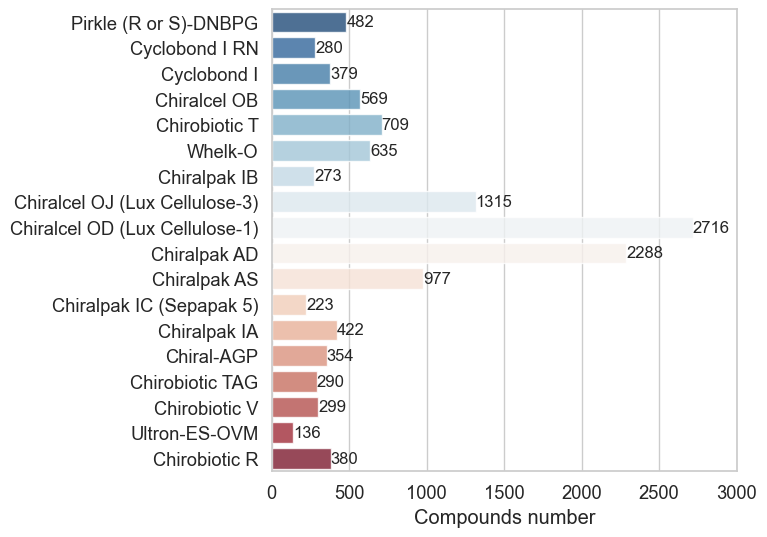

In [36]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
sns.barplot(x=df_cnt['Compound_Number'], y=df_cnt['CSP_Names'], ax=ax, 
            orient='h', order=order_re, 
            ci=None,
            palette="RdBu_r", alpha=0.8, )
for i in ax.containers:
    ax.bar_label(i, size=12)
    
ax.set(xlabel='Compounds number', ylabel='', xlim=(0, 3000))

plt.savefig('./best_csp_stat1203.eps', dpi=600, bbox_inches='tight', format='eps')
plt.savefig('./best_csp_stat1203.png', dpi=600, bbox_inches='tight')
plt.show()

e.g. 

In [37]:
g = df_pred.groupby('SMILES')
size = g.size()

In [38]:
size[size > 3]

SMILES
C#C[C@H](O)c1ccccc1                   7
C1CCN(C[C@@H]2CO2)C1                  4
C1CCN(C[C@@H]2CO2)CC1                 4
C1CN(C[C@@H]2CO2)CCO1                 4
C=C(C)C(=O)OC[C@H]1CO1                4
                                     ..
c1ccc2c(c1)CCC[C@@H]2C1=NCCN1         5
c1ccc2c(c1)CCC[C@@H]2Cc1ccncc1        4
c1ccc2c(c1)CCc1ccccc1N2C[C@@H]1CO1    4
c1ccc2c(c1)C[C@H]2Cn1ccnc1            4
c1ccc2c(c1)Sc1ccccc1N2C[C@@H]1CO1     4
Length: 861, dtype: int64

In [39]:
df_pred[df_pred['SMILES'] == 'C#C[C@H](O)c1ccccc1']

,index,ID,SMILES,MB,Pred_avg,Class,Pred,Class_b,Pred_b
396,126,chira_030543,C#C[C@H](O)c1ccccc1,0,"9.089221e-07,3.879593e-08,0.99999857,4.3209198...",2,"9.089221180147433e-07,3.879592824773681e-08,0....",1,0.731058
11628,550,chira_015978,C#C[C@H](O)c1ccccc1,6,"0.0010931309,0.99890673,1.4078519e-07,2.065927...",2,"0.0010931309079751372,0.9989067316055298,1.407...",1,0.268941
43944,1542,chira_014355,C#C[C@H](O)c1ccccc1,8,"0.00018531828,1.9934385e-05,0.9997305,6.424076...",2,"0.00018531827663537115,1.9934384908992797e-05,...",1,0.730978
56632,16,chira_000146,C#C[C@H](O)c1ccccc1,10,"5.8463762e-08,8.9654867e-07,0.9999989,2.073780...",2,"5.846376183171742e-08,8.965486699707981e-07,0....",1,0.731058
75862,794,chira_014356,C#C[C@H](O)c1ccccc1,11,"1.0651703e-06,0.9999987,5.1766746e-09,2.164765...",1,"1.0651702950781328e-06,0.9999986886978149,5.17...",0,0.268942
81930,22,chira_021479,C#C[C@H](O)c1ccccc1,14,"6.049755e-08,0.99999774,9.502363e-08,2.0896907...",1,"6.049754830428355e-08,0.9999977350234985,9.502...",0,0.268942
86624,200,chira_030595,C#C[C@H](O)c1ccccc1,16,"0.9993311,0.0001380365,0.00038517153,0.0001457...",0,"0.9993311166763306,0.00013803649926558137,0.00...",0,0.269150


In [40]:
df_label_all[df_label_all['SMILES'] == 'C#C[C@H](O)c1ccccc1']

,SMILES,MB,K2/K1,Y
146,C#C[C@H](O)c1ccccc1,10,1.20,2
14355,C#C[C@H](O)c1ccccc1,8,1.73,2
14356,C#C[C@H](O)c1ccccc1,11,1.14,1
15978,C#C[C@H](O)c1ccccc1,6,1.86,2
21479,C#C[C@H](O)c1ccccc1,14,1.15,1
30543,C#C[C@H](O)c1ccccc1,0,1.37,2
30595,C#C[C@H](O)c1ccccc1,16,1.10,0
